# Modeling MBSA dataset using Neural Network
 
This tutorial shows how to use **Neural Network** to model **Mouse Brain Sagittal Anterior** dataset, including the parameter tuning process. The resulting figures are saved in the figure folder.

## Content
* [Data preprocess](#data-preprocess)
  1. [Reading Visium data](#reading-visium-data)
  2. [Quality Control](#quality-control)
* [Making dataset](#making-dataset)
  1. [Label and feature](#label-and-feature)
  2. [Splitting dataset](#splitting-dataset)
* [Neural Network](#neural-network)
  1. [Tuning parameters](#tuning-parameters)
  2. [Final model](#final-model)

## Data preprocess

First, load packages.

In [1]:
import os
os.chdir("..")
import scanpy as sc
import numpy as np
import itertools

import datapre as DP
from model import nn_model
from model import hyper_opt as hop
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 1
dirname = "mouse_brain_sagittal_anterior"

d:\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the default **Cell Neighborhood Radius** to 1.0.

In [2]:
NEIGHBOR_DIS = 1.0

### Reading Visium data

Mark mitochondrial genes. Visualize using the `FeaturePlot` function.

d:\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


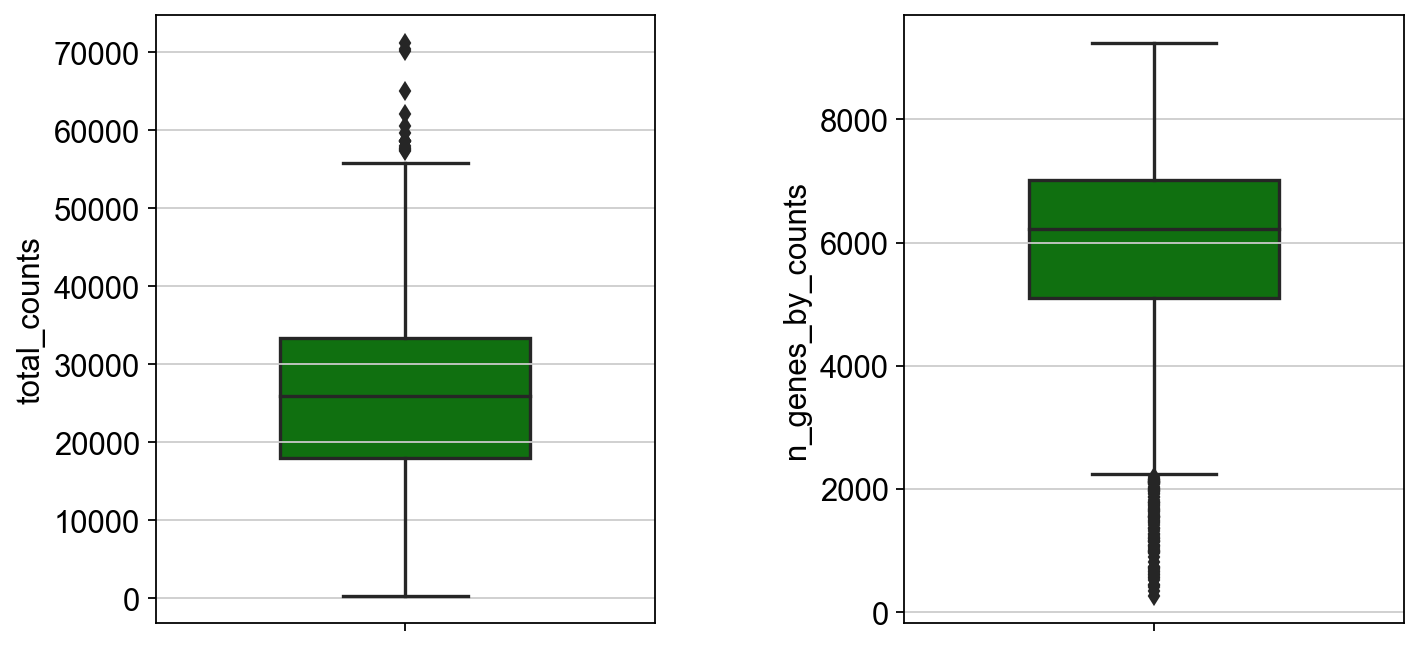

In [3]:
adata = sc.datasets.visium_sge(sample_id = "V1_Mouse_Brain_Sagittal_Anterior")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
DP.feature_plot(adata)

### Quality Control

Filter genes with total expression less than 10. For other QC, you can refer to `DP.Filter` function.

In [4]:
sc.pp.filter_genes(adata, min_counts = 10)

## Making dataset

Globally set the seed.

In [5]:
DP.setup_seed(38)

### Label and feature

Run [SpaGene.R](../spagene.R) to identify spatially variable genes.

In [6]:
DP.adata2seurat(adata, "V1_Mouse_Brain_Sagittal_Anterior")
! Rscript spagene.R V1_Mouse_Brain_Sagittal_Anterior 200
spagene = DP.find_spa("data/V1_Mouse_Brain_Sagittal_Anterior/spagene.txt")

Loading required package: ggplot2
Loading required package: patchwork


## Neural Network

### Final model

In [7]:
train_data, test_data, tt_data = DP.dataset_blind(adata, spagene, NEIGHBOR_DIS, neg_size = 100)

In [8]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# over = SMOTE(sampling_strategy = 0.05)
# under = RandomUnderSampler(sampling_strategy = 0.2)
# steps = [('o', over), ('u', under)]
# #steps = [("o", over)]
# pipeline = Pipeline(steps = steps)
# train_feature, train_label = pipeline.fit_resample(train_data.feature, train_data.label)

第0轮，训练损失：0.0596
第0轮，验证损失：0.0465
Validation loss decreased (inf --> 0.046470).  Saving model ...
第1轮，训练损失：0.0499
第1轮，验证损失：0.0450
Validation loss decreased (0.046470 --> 0.045033).  Saving model ...
第2轮，训练损失：0.0467
第2轮，验证损失：0.0416
Validation loss decreased (0.045033 --> 0.041635).  Saving model ...
第3轮，训练损失：0.0449
第3轮，验证损失：0.0402
Validation loss decreased (0.041635 --> 0.040217).  Saving model ...
第4轮，训练损失：0.0434
第4轮，验证损失：0.0398
Validation loss decreased (0.040217 --> 0.039771).  Saving model ...
第5轮，训练损失：0.0421
第5轮，验证损失：0.0391
Validation loss decreased (0.039771 --> 0.039081).  Saving model ...
第6轮，训练损失：0.0416
第6轮，验证损失：0.0383
Validation loss decreased (0.039081 --> 0.038324).  Saving model ...
第7轮，训练损失：0.0407
第7轮，验证损失：0.0375
Validation loss decreased (0.038324 --> 0.037483).  Saving model ...
第8轮，训练损失：0.0400
第8轮，验证损失：0.0382
EarlyStopping counter: 1 out of 7
第9轮，训练损失：0.0390
第9轮，验证损失：0.0370
Validation loss decreased (0.037483 --> 0.037043).  Saving model ...
第10轮，训练损失：0.0387
第10轮，验证损失：0.0

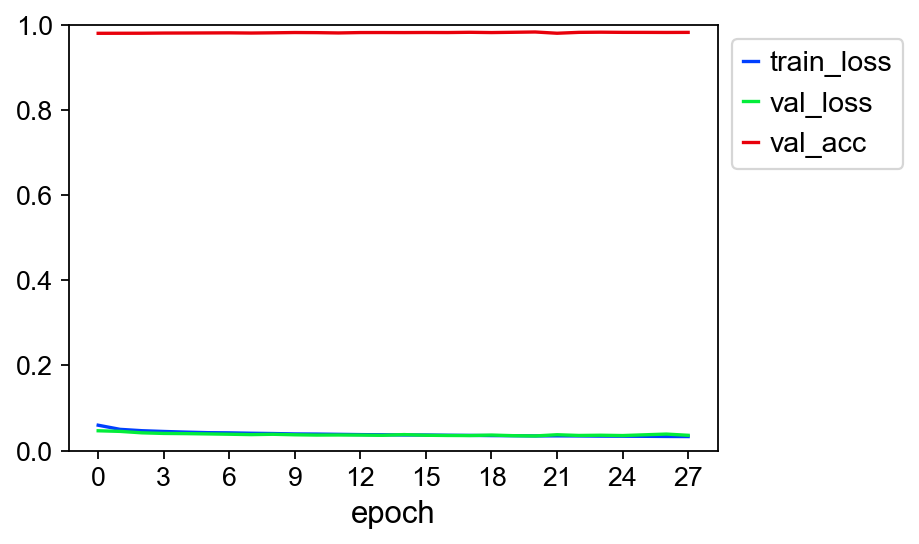

0.0013727185
0.0013727185
0.74144953


d:\work\evaluation.py:462: RuntimeWarning: invalid value encountered in divide
  f = (1+beta**2) * p * r / ((p + r) * beta**2)


{'Accuracy': 0.9933085501858736,
 'Precision': 0.10909090909090909,
 'Recall': 0.3380281690140845,
 'MCC': 0.1893482186393973,
 'F1_Score': 0.16494845360824742,
 'AUC': 0.9854664628317306,
 'Average Precision': 0.10612841909341385,
 'confusion_matrix': array([[36048,   196],
        [   47,    24]], dtype=int64)}

In [9]:
nnmodel = nn_model.NeuralNetworkClassifier(
    num_features = 200, 
    batch_size = 128,
    hidden_layer_sizes = (500, 100),
    dropout_rate = 0.5,
    class_weight = None
)
nnmodel.fit(train_data.feature, train_data.label)
pred = nnmodel.predict(test_data.feature)
predprob = nnmodel.predict_proba(test_data.feature)
eval.evaluate(test_data.label, pred, predprob, verbose = False)

In [12]:
pred = nnmodel.predict(tt_data.feature)
predprob = nnmodel.predict_proba(tt_data.feature)
eval.evaluate(tt_data.label, pred, predprob, verbose = False)

0.0034905493
0.0034905493
0.519033


{'Accuracy': 0.9934173348606339,
 'Precision': 0.11473656057769457,
 'Recall': 0.3002099370188943,
 'MCC': 0.1827850923252679,
 'F1_Score': 0.1660216718266254,
 'AUC': 0.9849005165039807,
 'Average Precision': 0.10382921728597021,
 'confusion_matrix': array([[650011,   3310],
        [  1000,    429]], dtype=int64)}

neg_size = 100 + smote_undersample = [0.05, 0.1] + class_weight = [1, 2]：0.064 + 0.859\
neg_size = 100 + smote_undersample = [0.05, 0.2] + class_weight = [1, 1]：0.058 + 0.929\
neg_size = 100 + smote_undersample = [0.05, 0.2] + class_weight = [1, 2]：0.052 + 0.901\
neg_size = 100 + smote = 0.05 + class_weight = [1, 4]：0.052 + 0.859\
neg_size = 100 + smote = 0.1 + class_weight = [1, 2]：0.064 + 0.746